In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.extend([ '../', '../data'])
import torch
import torch.nn as nn
import torch.optim as optim
from data import input_data
import dataloader as dl
from args import Args
from model import Het_En, Classifier, EdgePredictor
from smote import smote
from train import train_smote, test_smote

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")
torch.cuda.empty_cache()

Current device: NVIDIA A100 80GB PCIe


In [2]:
args = Args() 
# data = input_data(args) 
# torch.save(data, 'data.pt')
data = torch.load('../data.pt')
print(data)

HeteroData(
  a={
    num_nodes=28645,
    y=[28645]
  },
  p={ num_nodes=21044 },
  v={ num_nodes=18 },
  p_title_embed={ x=[21044, 128] },
  p_abstract_embed={ x=[21044, 128] },
  p_net_embed={ x=[21044, 128] },
  p_a_net_embed={ x=[21044, 128] },
  p_p_net_embed={ x=[21044, 128] },
  p_v_net_embed={ x=[21044, 128] },
  a_net_embed={ x=[28645, 128] },
  a_text_embed={ x=[28645, 128] },
  v_net_embed={ x=[18, 128] },
  v_text_embed={ x=[18, 128] },
  (a, walk, a)={ edge_index=[2, 198912] },
  (a, walk, p)={ edge_index=[2, 144965] },
  (a, walk, v)={ edge_index=[2, 42500] },
  (p, walk, a)={ edge_index=[2, 137499] },
  (p, walk, p)={ edge_index=[2, 158408] },
  (p, walk, v)={ edge_index=[2, 29341] },
  (v, walk, a)={ edge_index=[2, 180] },
  (v, walk, p)={ edge_index=[2, 180] },
  (v, walk, v)={ edge_index=[2, 31] }
)


In [3]:
print(data['a','walk','p'].edge_index)

tensor([[    0,     0,     0,  ..., 28644, 28644, 28644],
        [11846, 11765, 12754,  ...,  4378, 20250,  6612]])


In [4]:
lr = 0.0001
num_epochs = 100
weight_decay = 5e-4
embed_dim = 128
dropout = 0.1
im_class_num = [1]
im_ratio = [0.8]
class_sample_num = 200
nclass = 4
node_dim = [args.A_n, args.P_n, args.V_n]

In [5]:
c_train_num = dl.train_num(data['a'].y, im_class_num, class_sample_num, im_ratio)
print(c_train_num, sum(c_train_num))
train_idx, val_idx, test_idx, c_num_mat = dl.segregate(data['a'].y, c_train_num)
print("train_idx: ", train_idx, len(train_idx))
print("val_idx: ", val_idx, len(val_idx))
print("test_idx: ", test_idx, len(test_idx))
# print(c_num_mat)

[200, 160, 200, 200] 760
0 3508
1 1946
2 2890
3 3016
train_idx:  [28370, 17013, 11181, 14734, 16810, 21814, 18235, 24321, 14388, 27916, 28525, 8359, 19583, 21997, 2962, 4146, 21743, 3431, 18674, 1223, 16439, 21146, 18039, 22353, 21302, 2040, 14186, 23593, 12782, 11597, 2741, 9939, 10439, 28262, 1379, 9350, 10857, 20850, 20388, 13109, 12261, 26809, 3240, 8470, 11010, 7214, 12702, 25309, 25460, 17193, 11017, 17092, 10910, 12116, 9610, 12085, 27054, 16462, 15355, 8685, 7413, 19576, 4976, 292, 19816, 21638, 19785, 25169, 2389, 19702, 21205, 18477, 346, 2016, 26553, 19721, 3298, 28562, 5651, 23151, 3357, 22569, 7188, 6049, 25913, 1693, 857, 1611, 17059, 14688, 8313, 19659, 25657, 26794, 18453, 21141, 5037, 246, 14450, 13534, 15724, 20784, 26971, 24791, 25124, 13763, 23109, 12201, 9486, 9524, 22800, 16131, 3925, 13340, 20954, 20105, 2797, 8602, 15250, 7348, 13977, 11645, 13506, 21474, 7542, 17497, 2518, 27850, 23003, 15655, 10181, 25405, 27797, 20153, 5719, 7844, 18414, 10058, 19858, 18658, 

In [6]:
encoder = Het_En(node_dim, embed_dim, dropout)
decoder = EdgePredictor(embed_dim)
classifier = Classifier(embed_dim, nclass, dropout)
#print(features.shape)

In [7]:
# new_features, new_labels , new_train_idx = smote(features = data['a_net_embed'].x, labels = data['a'].y, 
#                                             train_idx = train_idx, portion = 0, im_class_num = im_class_num)
# print(new_features.shape, new_labels.shape, new_train_idx.shape)

## Training Part

In [8]:
torch.cuda.empty_cache()
train_smote(data, encoder, classifier, decoder, num_epochs, lr, weight_decay, train_idx, val_idx, portion = 0, im_class_num = im_class_num, mode = 'sm')

Epoch [1/100], Loss: 1.4906, Accuracy: 0.2519, Edge Accuracy: 0.5151
Class 0:AUC-ROC- 0.4142, F1 Score- 0.4040; Class 1:AUC-ROC- 0.3039, F1 Score- 0.0000; Class 2:AUC-ROC- 0.3696, F1 Score- 0.0000; Class 3:AUC-ROC- 0.4220, F1 Score- 0.3325; Macro-Average AUC-ROC: 0.3774,Macro-Average F1 Score: 0.1841
Validation Loss: 1.4887, Validation Accuracy: 0.2500, Validation Edge Accuracy: 0.5142
Class 0:AUC-ROC- 0.6437, F1 Score- 0.2182; Class 1:AUC-ROC- 0.2455, F1 Score- 0.0000; Class 2:AUC-ROC- 0.4664, F1 Score- 0.0000; Class 3:AUC-ROC- 0.4299, F1 Score- 0.1689; Macro-Average AUC-ROC: 0.4464,Macro-Average F1 Score: 0.0968
Epoch [2/100], Loss: 1.4878, Accuracy: 0.2532, Edge Accuracy: 0.5142
Class 0:AUC-ROC- 0.5189, F1 Score- 0.4040; Class 1:AUC-ROC- 0.2954, F1 Score- 0.0000; Class 2:AUC-ROC- 0.3787, F1 Score- 0.0000; Class 3:AUC-ROC- 0.4857, F1 Score- 0.3634; Macro-Average AUC-ROC: 0.4197,Macro-Average F1 Score: 0.1919
Validation Loss: 1.4858, Validation Accuracy: 0.2500, Validation Edge Accura

In [9]:
adj_old = torch.zeros((data['a'].num_nodes, data['a'].num_nodes), dtype = torch.float32)
adj_old[data['a', 'walk', 'a'].edge_index[0], data['a', 'walk', 'a'].edge_index[1]] = 1.0
test_smote(data, encoder, classifier, decoder, test_idx, adj_old = adj_old, mode = 'sm', dataset = "Test")

Test Loss: 1.1115, Test Accuracy: 0.9455, Test Edge Accuracy: 0.5390
Class 0:AUC-ROC- 0.9815, F1 Score- 0.4915; Class 1:AUC-ROC- 0.9871, F1 Score- 0.3966; Class 2:AUC-ROC- 0.9513, F1 Score- 0.3330; Class 3:AUC-ROC- 0.9785, F1 Score- 0.5560; Macro-Average AUC-ROC: 0.9746,Macro-Average F1 Score: 0.4443


(0.9454545454545454, 0.974609268991453, 0.4442744329524726)

In [10]:
# # Data
# epochs = [1, 10, 25, 50, 75, 100, 150, 200, 250]
# Val_acc_list = [0.26, 0.27, 0.74, 0.93, 0.95, 0.96, 0.97, 0.95, 0.95]
# Val_auc_list = [0.5930095755030322, 0.9218978119106809, 0.9754136542837819, 0.9784269844215652, 0.9765362260372121, 0.974912021764024, 0.9702424321859386, 0.9674707975931053, 0.9723325504032536]
# Val_f1_list = [0.08704139176217651, 0.2710137586280392, 0.4676582449091463, 0.40927857505690307, 0.4027379825175418, 0.42018465302397967, 0.4479509540242464, 0.47347841881981045, 0.5090739839801877]

# # Create a figure and axis
# fig, ax = plt.subplots()

# # Plot the data
# ax.plot(epochs, Val_acc_list, label='Validation Accuracy', color='blue')
# ax.plot(epochs, Val_auc_list, label='Validation Macro-AUC', color='red')
# ax.plot(epochs, Val_f1_list, label='Validation Macro-F1', color='green')

# # Add a legend
# ax.legend()
# ax.grid(True)

# # Add labels and a title
# ax.set_xlabel('Epoch')
# ax.set_title('Validation Metrics over Epochs')

# # Set y-axis ticks and labels
# y_ticks = np.arange(0, 1.1, 0.1)  # Specify the tick positions
# ax.set_yticks(y_ticks)            # Set the tick positions
# #ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.43', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.96', '1.0'])  # Set the tick labels

# # Show the plot
# plt.show()

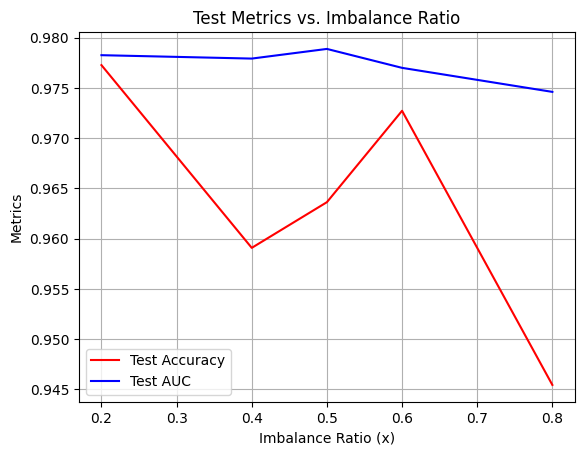

In [12]:
x = [0.2, 0.4, 0.5, 0.6, 0.8]
test_acc = [0.9772727272727273, 0.9590909090909091, 0.9636363636363636, 0.9727272727272728, 0.9454545454545454]
test_auc = [0.9782603592869176, 0.97792235625688, 0.9788833247041199, 0.9769999439197554, 0.974609268991453]
# test_f1 = [0.397908388210513, 0.4560713470673279, 0.4303643592533385, 0.44008181913702576, 0.4442744329524726]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, test_acc, label='Test Accuracy', color='red')
ax.plot(x, test_auc, label='Test AUC', color='blue')
# ax.plot(x, test_f1, label='Test F1', color='green')

# Add a legend
ax.legend()

# Add labels and a title
ax.set_xlabel('Imbalance Ratio (x)')
ax.set_ylabel('Metrics')
ax.set_title('Test Metrics vs. Imbalance Ratio')

# Add grid
ax.grid(True)

# Show the plot
plt.show()